In [5]:
!pip install torch numpy torchvision scikit-learn matplotlib

  Using cached torch-2.2.2-cp310-cp310-win_amd64.whl (198.6 MB)
  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
  Using cached torchvision-0.17.2-cp310-cp310-win_amd64.whl (1.2 MB)
     ---------------------------------------- 10.6/10.6 MB 5.3 MB/s eta 0:00:00
  Using cached matplotlib-3.8.4-cp310-cp310-win_amd64.whl (7.7 MB)
  Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
  Using cached filelock-3.13.4-py3-none-any.whl (11 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached Jinja2-3.1.3-py3-none-any.whl (133 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)
  Using cached pillow-10.3.0-cp310-cp310-win_amd64.whl (2.5 MB)
     ---------------------------------------- 46.2/46.2 MB 4.3 MB/s eta 0:00:00
     -------------------------------------- 301.2/301.2 kB 3.7 MB/s eta 0:00:00
  Using cached contourpy-1.2.1-cp310-cp310-win_amd64.whl (187 kB)
  Using cached fonttools-4.51.0-cp310-cp310-win_amd64.whl (2.2 MB)
  Using cached cycler-0.12


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Closest filenames:
204331.jpg
204038.jpg
7793987.jpg
204740.jpg
7793998.jpg
7794631.jpg
7794634.jpg
7793398.jpg
57823246.jpg
204549.jpg


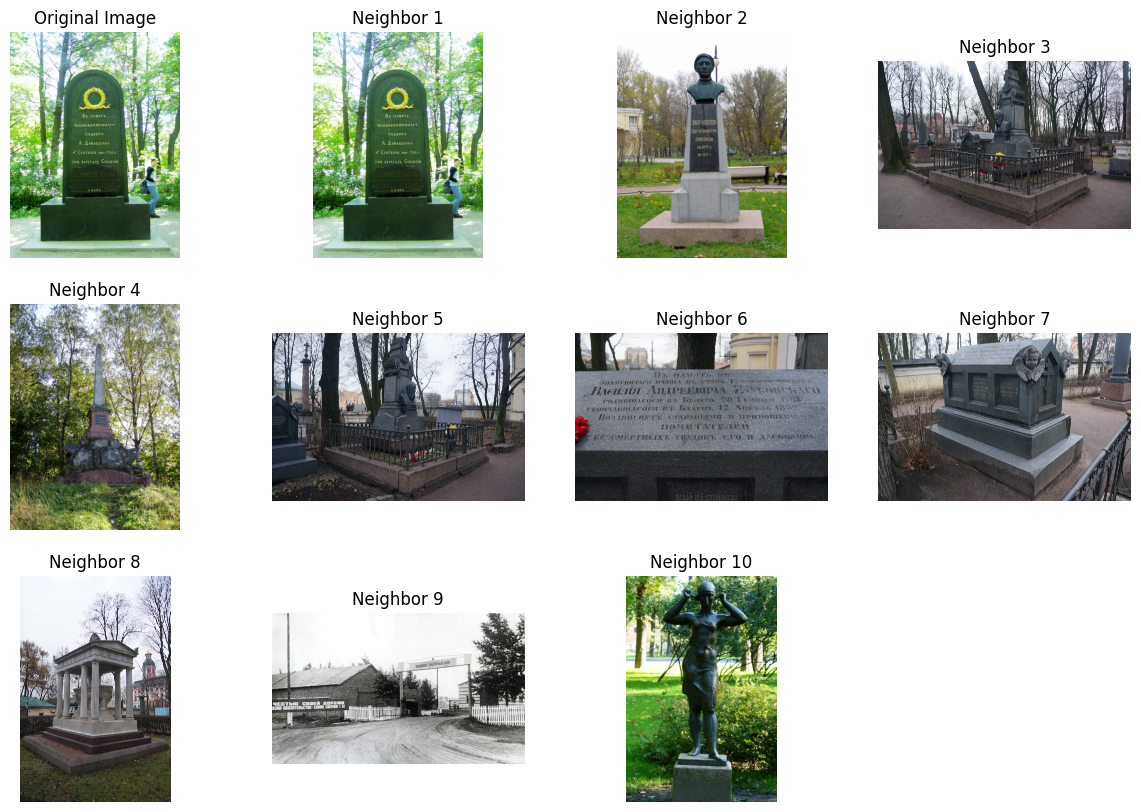

In [8]:
import torch
import numpy as np
from torch import nn
from torchvision import transforms
from torchvision.models import resnet50
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import matplotlib.pyplot as plt
import os

# Определение модели
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        self.base_model = resnet50(pretrained=True)
        self.base_model.fc = nn.Identity()  # Удаление последнего слоя классификации

    def forward(self, x):
        return self.base_model(x)

# Инициализация модели и перевод ее на доступное устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleResNet().to(device)
model.eval()

# Функция для преобразования изображения в эмбеддинг
def image_to_embedding(image_path, model, device):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image)
    return embedding.cpu().numpy()

# Загрузка нового изображения и получение эмбеддинга
new_image_path = r"C:/Users/user/Desktop/госкатлог/train-t/204331.jpg"
new_embedding = image_to_embedding(new_image_path, model, device)

# Загрузка сохраненных эмбеддингов и имен файлов
embeddings = np.load(r"C:/Users/user/Desktop/госкатлог/transformer/saved_embeddings.npy")
filenames = np.load(r"C:/Users/user/Desktop/госкатлог/transformer/saved_labels.npy", allow_pickle=True)

# Инициализация и обучение модели ближайших соседей
neighbors = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
neighbors.fit(embeddings)

# Поиск 10 ближайших эмбеддингов в базе
distances, indices = neighbors.kneighbors(new_embedding)

# Получение имен файлов с наиболее близкими эмбеддингами
closest_filenames = filenames[indices[0]]
print("Closest filenames:")
for filename in closest_filenames:
    print(filename)

# Визуализация изображений
def plot_images(main_image_path, similar_images):
    plt.figure(figsize=(15, 10))
    # Отображение исходного изображения
    img = Image.open(main_image_path)
    plt.subplot(3, 4, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    # Отображение похожих изображений
    for idx, filename in enumerate(similar_images, 2):
        img_path = os.path.join(r"C:/Users/user/Desktop/госкатлог/train-t", filename)
        img = Image.open(img_path)
        plt.subplot(3, 4, idx)
        plt.imshow(img)
        plt.title(f"Neighbor {idx-1}")
        plt.axis('off')
    
    plt.show()

plot_images(new_image_path, closest_filenames)
